- model : resnet152
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(resnet152.fc.parameters(pretrained=True), lr = 0.001)
- lr_scheduler : StepLR(optim, step_size=7, gamma=0.1)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
from torchvision.models import resnet152

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [2]:
# random_seed를 바꿔가며 모델 학습 진행.
random_seed = 7563
torch.manual_seed(random_seed)

In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [4]:
train_set = torchvision.datasets.ImageFolder(root = './Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './Validation_9857834a3b',
                                           transform = trans)

In [5]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [6]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=4)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [8]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_resnet152 = resnet152(pretrained=True)

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True
for param in model_resnet152.parameters():
    param.requires_grad = False
    
num_ftrs = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_ftrs, 5)

model_resnet152 = model_resnet152.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_resnet152.fc.parameters(), lr = 0.001)

# 7에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
best_resnet152 = train_model(model_resnet152, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5749 F1-Score: 0.6628
val Loss: 0.5427 F1-Score: 0.6303

Epoch 1/24
----------
train Loss: 0.3354 F1-Score: 0.7833
val Loss: 0.2651 F1-Score: 0.8215

Epoch 2/24
----------
train Loss: 0.2786 F1-Score: 0.8125
val Loss: 0.5131 F1-Score: 0.6420

Epoch 3/24
----------
train Loss: 0.2785 F1-Score: 0.8279
val Loss: 0.2180 F1-Score: 0.8520

Epoch 4/24
----------
train Loss: 0.2440 F1-Score: 0.8450
val Loss: 0.1810 F1-Score: 0.8826

Epoch 5/24
----------
train Loss: 0.2109 F1-Score: 0.8475
val Loss: 0.2372 F1-Score: 0.8305

Epoch 6/24
----------
train Loss: 0.2126 F1-Score: 0.8585
val Loss: 0.1930 F1-Score: 0.8898

Epoch 7/24
----------
train Loss: 0.1673 F1-Score: 0.8923
val Loss: 0.1500 F1-Score: 0.9060

Epoch 8/24
----------
train Loss: 0.1655 F1-Score: 0.8986
val Loss: 0.1451 F1-Score: 0.9130

Epoch 9/24
----------
train Loss: 0.1602 F1-Score: 0.8980
val Loss: 0.1422 F1-Score: 0.9129

Epoch 10/24
----------
train Loss: 0.1599 F1-Score: 0.8990
val Loss: 0.1483 F1-Score: 0.9176

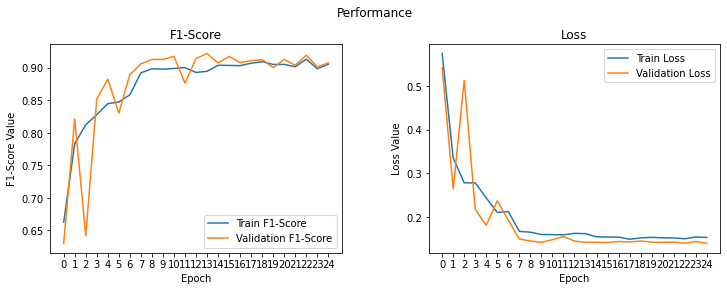

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 25 #에폭사이즈
ax1.plot(range(epochs), flscores['train'], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'], label='Train Loss')
ax2.plot(range(epochs), losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [13]:
filname = 'best_Resnet152_norm0485'
f.savefig(filname, dpi = 300)

In [14]:
best_resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
torch.save(best_resnet152, 'ResNet152norm0485.pt')

In [16]:
joblib.dump(best_resnet152, 'ResNet152norm0485.pkl')

['ResNet152norm0485.pkl']